### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras import optimizers
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import scipy
import scipy.stats
import csv

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#現在の最大表示行数の出力
pd.set_option("display.max_rows",5000)
#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 80)

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11953225028462461084,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17045686989806470959
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9876635648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14013274785100112020
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2140773565139472757
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fix Random Seed

In [5]:
import tensorflow as tf
import numpy as np
import random
import os

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [6]:
pwd()

'C:\\Users\\tamon\\Desktop'

### Loading the Data sets

In [7]:
# train = pd.read_csv('RBS/input/result_label.csv')
# train = train[train['label']==1].reset_index(drop=True)
# train

In [8]:
train = pd.read_csv('RBS/input/train_data.csv')
print(train.shape)

# put labels into y_train variable
Y_train = train["translation_rate"]
# Drop 'label' column
X_train = train["seq"]

train.head()

(2031, 5)


,seq,in,out,translation_rate,bin
0,TAAAGAAAAAGAAGG,110.0,305.0,5.992353,8
1,TAAAGAAAACACAGG,189.0,357.0,4.976531,6
2,TAAAGAAAACTTAGG,106.0,108.0,3.342884,5
3,TAAAGAAAAGGTAGG,208.0,1331.0,8.205625,10
4,TAAAGAAACAGAAGG,84.0,266.0,6.343929,8


In [9]:
# test = pd.read_csv('RBS/input/test.csv')
# print(test.shape)
# Y_test = test['OD']
# X_test = test["seq"]

# test['seq'] = 'TAAAG' + test['seq'] + 'AGG'
# test.head(3)

### Visualize Distribution of the Data Sets

NameError: name 'Y_test' is not defined

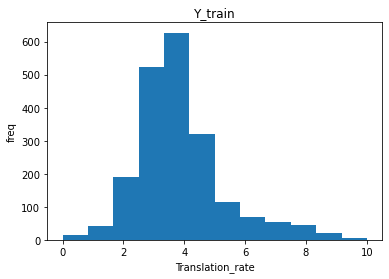

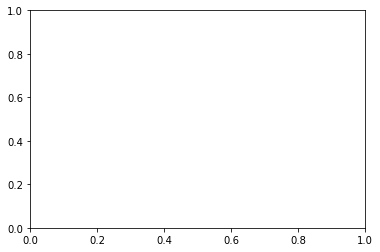

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.hist(Y_train, bins=12)
ax1.set_title('Y_train')
ax1.set_xlabel('Translation_rate')
ax1.set_ylabel('freq')

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.hist(Y_test, bins=12)
ax2.set_title('Y_test')
ax2.set_xlabel('Translation_rate')
ax2.set_ylabel('freq')

plt.show()

### Label Encoding 
- Encode labels to one hot vectors 
    - A => [1,0,0,0] 
    - C => [0,1,0,0] 
    - G => [0,0,1,0] 
    - T => [0,0,0,1]

In [13]:
def one_hot(df):
    one_hot_seq = []
    for seq in df:
        le = preprocessing.LabelEncoder()
        le.fit(["A","T","G","C"])
        one_hot_seq.append(np.identity(4)[le.transform(list(seq))])
    return np.array(one_hot_seq)

X_tr = one_hot(X_train)
# X_te = one_hot(X_test)

Y_tr = np.array(Y_train)
# Y_te = np.array(Y_test)

print(np.shape(X_train))
# print(np.shape(X_test))

X_tr.shape

(2031,)


(2031, 15, 4)

In [14]:
X_tr

array([[[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       ...,

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0.

### Build Model 
- We build CNN 
    1. Conv1D 
    2. Dropout 
    3. Conv1D 
    4. Dropout 
    5. MaxPooling1D 
    6. Flatten 
    7. Dense 
    8. Dense 

In [15]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional,LSTM
from keras.layers import Embedding,SimpleRNN

In [51]:
def build_model():
    model = Sequential()
    #layer1
    model.add(Conv1D(filters=7, kernel_size=1, strides=1,activation="linear", input_shape=(15,4), name = 'layer1'))
    model.add(Dropout(0.15))
    
    #layer2
    model.add(Conv1D(filters=5, kernel_size=1, strides=1,activation="linear", name = 'layer2'))
    model.add(Dropout(0.15))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())

    #layer3
    model.add(Dense(units=64, activation="relu"))

    #layer4
    model.add(Dense(units = 1))

    # compile the model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics = ['mean_squared_error'])
    
    return model

In [17]:
# def build_model():
#     model = Sequential()
#     #layer2
#     model.add(CuDNNLSTM(units=66,input_shape=(7,4)))
#     model.add(Dropout(0.2))

#     #layer3
#     model.add(Dense(units = 1))

#     # compile the model
#     model.compile(loss="mean_squared_error", optimizer="adam", metrics = ['mean_squared_error'])
    
#     return model

In [18]:
def build_model():
    model = Sequential()
    #layer1
    model.add(Conv1D(filters=5, kernel_size=1, strides=1,activation="linear", input_shape=(15,4), name = 'layer1'))
    model.add(Dropout(0.2))
    
    #layer2
    model.add(Conv1D(filters=16,padding='same',kernel_size=2, activation="linear", name = 'layer2'))
    model.add(Dropout(0.2))
    
    #layer4
    model.add(Dense(units = 66))

    #layer3
    model.add(Bidirectional(LSTM(66, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=66)))
    model.add(Dropout(0.2))
    
#     model.add(CuDNNLSTM(units=66))
#     model.add(Dropout(0.2))

    #layer4
    model.add(Dense(units = 1))

    # compile the model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics = ['mean_squared_error'])
    
    return model

In [19]:
model = build_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv1D)              (None, 15, 5)             25        
_________________________________________________________________
dropout (Dropout)            (None, 15, 5)             0         
_________________________________________________________________
layer2 (Conv1D)              (None, 15, 16)            176       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 16)            0         
_________________________________________________________________
dense (Dense)                (None, 15, 66)            1122      
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 132)           70224     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 132)               1

### 10 Fold Cross Validation 
- We split the data into train and validation 
- train 90% 
- validation 10%

In [21]:
# ホールドアウト法
# x_train, x_valid, y_train, y_valid = train_test_split(X_tr, Y_tr, test_size=0.2, random_state=42)

# model.fit(X_tr,Y_tr,batch_size=2,epochs=100,verbose=0)

In [22]:
index = 0
set_seed(0)

# loss
train_loss = []
val_loss = []

# validation result
val_seq = []
val_predict = []
val_label = []

# correlation
train_correlation = []
val_correlation = []
test_correlation = []

# エラー分析
index_tr = []
index_va = []

In [23]:
from sklearn.metrics import r2_score

In [24]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for train_index, val_index in kf.split(X_train):
    
    x_train, x_val = X_tr[train_index], X_tr[val_index]
    y_train, y_val = Y_tr[train_index], Y_tr[val_index]
    
    
    
    # shuffle train data
    for l in [x_train, y_train]:
        np.random.seed(1)
        np.random.shuffle(l)
        
    
    index_tr.append(train_index)
    index_va.append(val_index)    
    
    model_weights = "RBS/jupyter/weight/regression_model[%d].h5" % index
    index = index+1
    
    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10 , verbose=1)
    checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=0, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,min_lr=0.0001)
    
    # load_model
    model = build_model()
    
    # run
    history = model.fit(x_train, y_train, batch_size=2, 
              epochs = 100, verbose=0, 
              validation_data=(x_val, y_val),
              callbacks=[early_stopping, checkpointer, reduce_lr])
    
    # save log
    # loss
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # validation result
    val_seq.extend([X_train[val_index[i]] for i in range(len(val_index))])
    val_predict.extend([x[0] for x in model.predict(x_val, verbose=1)])
    val_label.extend(y_val)
    
    
    tr_pre = model.predict(x_train, verbose=1)
    val_pre = model.predict(x_val, verbose=1)
    
#     test_pre = model.predict(X_te, verbose=1)
    
    # train correlation
    train_correlation.append(r2_score(y_train,tr_pre))
                   
    # validation correlation
    val_correlation.append(r2_score(y_val,val_pre))
    
#     # test correlation
#     test_correlation.append(r2_score(Y_te,test_pre))
    
print(train_correlation)
print('学習データに対する決定係数:',sum(train_correlation)/10)

print(val_correlation)
print('評価データに対する決定係数:',sum(val_correlation)/10)

# print(test_correlation)
# print('テストデータに対する決定係数:',sum(test_correlation)/10)

KeyboardInterrupt: 

In [ ]:
# train.iloc[index_va[0],:]['bin'].value_counts()

In [ ]:
# train.iloc[index_va[4],:]['bin'].value_counts()

In [ ]:
# train.iloc[index_va[1],:]['bin'].value_counts()

In [ ]:
# train.iloc[index_va[6],:]['bin'].value_counts()

### Output Files

In [549]:
pwd()

'C:\\Users\\tamon\\Desktop'

In [550]:
print('train_loss : ', np.shape(train_loss))
print('val_loss : ', np.shape(val_loss))
print('val_seq : ', np.shape(val_seq))
print('val_predict : ', np.shape(val_predict))
print('val_label : ', np.shape(val_label))
# print('test_predict : ', np.shape(test_predict))
print('X_test : ', np.shape(X_test))
print('Y_test : ', np.shape(Y_test))

# train, validation loss
# for i in range(10):
#     loss = pd.DataFrame(np.concatenate([[train_loss[i]], [val_loss[i]]]).T, columns = ['%d_train'%(i+1), '%d_val'%(i+1)])  
#     loss.to_csv('RBS/jupyter/output/%d_loss.csv'%(i+1), index = False )

# validation result
validation_result = pd.DataFrame(np.concatenate([[val_seq], [val_label], [val_predict]]).T,  columns = ['seq', 'translation_rate', 'predict'])
validation_result.to_csv('RBS/jupyter/output/validation_result.csv', index = False)



train_loss :  (10,)
val_loss :  (10,)
val_seq :  (2031,)
val_predict :  (2031,)
val_label :  (2031,)
X_test :  (60,)
Y_test :  (60,)


### Predict Test Data Sets

In [472]:
test_correlation = []
test_predict = []

In [473]:
# load saved weights and models
for index in range(10):
    model = load_model("RBS/jupyter/weight/model2/regression_model[%d].h5" % index, compile=False)
    
    test_predict.append([x[0] for x in model.predict(X_te, verbose=1)])
    test_correlation.append(scipy.stats.pearsonr(Y_te.flatten(), model.predict(X_te, verbose=1).flatten())[0]**2)

print(test_correlation)   
print(sum(test_correlation)/10)

2/2 [==============================] - 0s 2ms/step
[0.29897227952139294, 0.2964227928382206, 0.19093305234460659, 0.31874951560330245, 0.18808602455487988, 0.28543913329363263, 0.2940568723395796, 0.24223764077713406, 0.3686374029661395, 0.26992105856966775]
0.2753455772808556


In [243]:
# test result
test_result = pd.DataFrame(np.concatenate([[X_test], [Y_test], [np.mean(test_predict, axis=0).flatten()]]).T,  columns = ['seq', 'translation_rate', 'predict'])
test_result.to_csv('RBS/jupyter/output/test_result.csv', index = False)

### Visualize the Prediction Result

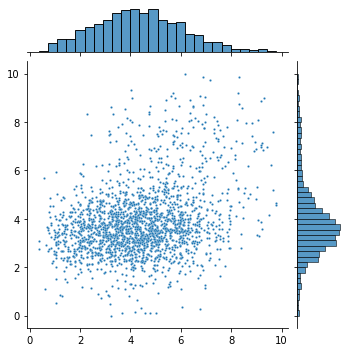

In [244]:
# data
x = np.mean(test_predict, axis=0).flatten()
y = Y_te.flatten()

# calculate R^2
r2 = scipy.stats.pearsonr(x, y)[0]**2


g = sns.jointplot(x,
                  y,
                  kind = 'scatter',
                  s = 5,
                  alpha = 1,
                  size = 5)

In [35]:
pre_result = pd.read_csv('RBS/jupyter/output/test_result.csv')

# boost = pre_result[pre_result['translation_rate']>pre_result['predict']].reset_index(drop=True)
# refrain = pre_result[pre_result['translation_rate']<pre_result['predict']].reset_index(drop=True)

gomi = pre_result[(abs(pre_result['translation_rate']-pre_result['predict'])>1.8)].reset_index(drop=True)
pre_result = pre_result[(abs(pre_result['translation_rate']-pre_result['predict'])<=1.8)].reset_index(drop=True)

In [36]:
# boost = pre_result[pre_result['translation_rate']>pre_result['predict']].reset_index(drop=True)
# # pre_result = pd.concat([pre_result,boost]).reset_index(drop=True)

# refrain = pre_result[pre_result['translation_rate']<pre_result['predict']].reset_index(drop=True)

In [37]:
print(pre_result.shape)
print(boost.shape)
print(gomi.shape)
print(refrain.shape)

(1299, 3)


NameError: name 'boost' is not defined

In [38]:
refrain['seq'].map(lambda x:str(x)[5:12])

NameError: name 'refrain' is not defined

In [39]:
def ATG_find(x):
    count=0
    if 'TCATG' in str(x):
        return 'TCATG'
    else:
        return str(x)

In [40]:
refrain['TCATG'] = refrain['seq'].map(ATG_find)
refrain[refrain['TCATG']=='TCATG'].shape

NameError: name 'refrain' is not defined

In [41]:
boost['TCATG'] = boost['seq'].map(ATG_find)
boost[boost['TCATG']=='TCATG'].shape

NameError: name 'boost' is not defined

In [42]:
# refrain['ATG'] = refrain['seq'].map(ATG_find)
# refrain[refrain['ATG']=='ATG'].shape

In [43]:
# boost

In [45]:
pre_result.to_csv('RBS/input/pre_result.csv', index=False)
gomi.to_csv('RBS/input/gomi.csv', index=False)

In [46]:
gomi_tr = one_hot(gomi['seq'])
gomi_te = np.array(gomi['translation_rate'])
gomi_tr.shape

(732, 15, 4)

In [52]:
# put labels into y_train variable
Y_train = pre_result["translation_rate"]
# Drop 'label' column
X_train = pre_result["seq"]


pre_result.head(3)
pre_result.shape

(1299, 3)

In [53]:
def one_hot(df):
    one_hot_seq = []
    for seq in df:
        le = preprocessing.LabelEncoder()
        le.fit(["A","T","G","C"])
        one_hot_seq.append(np.identity(4)[le.transform(list(seq))])
    return np.array(one_hot_seq)

X_tr = one_hot(X_train)
# X_te = one_hot(X_test)
Y_tr = np.array(Y_train)
# Y_te = np.array(Y_test)

print(np.shape(X_train))
# print(np.shape(X_test))

X_tr.shape

(1299,)


(1299, 15, 4)

In [54]:
index = 0
set_seed(0)

# loss
train_loss = []
val_loss = []

# validation result
val_seq = []
val_predict = []
val_label = []

# correlation
train_correlation = []
val_correlation = []
test_correlation = []

# エラー分析
index_tr = []
index_va = []

In [55]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for train_index, val_index in kf.split(X_train):
    
    x_train, x_val = X_tr[train_index], X_tr[val_index]
    y_train, y_val = Y_tr[train_index], Y_tr[val_index]
    
    
    
    # shuffle train data
    for l in [x_train, y_train]:
        np.random.seed(1)
        np.random.shuffle(l)
        
    
    index_tr.append(train_index)
    index_va.append(val_index)    
    
    model_weights = "RBS/jupyter/weight/model2/regression_model[%d].h5" % index
    index = index+1
    
    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10 , verbose=1)
    checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=0, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,min_lr=0.0001)
    
    # load_model
    model = build_model()
    
    # run
    history = model.fit(x_train, y_train, batch_size=2, 
              epochs = 100, verbose=0, 
              validation_data=(x_val, y_val),
              callbacks=[early_stopping, checkpointer, reduce_lr])
    
    # save log
    # loss
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # validation result
    val_seq.extend([X_train[val_index[i]] for i in range(len(val_index))])
    val_predict.extend([x[0] for x in model.predict(x_val, verbose=1)])
    val_label.extend(y_val)
    
    
    tr_pre = model.predict(x_train, verbose=1)
    val_pre = model.predict(x_val, verbose=1)
    
#     test_pre = model.predict(X_te, verbose=1)
    
    # train correlation
    train_correlation.append(r2_score(y_train,tr_pre))
                   
    # validation correlation
    val_correlation.append(r2_score(y_val,val_pre))
    
#     # test correlation
#     test_correlation.append(r2_score(Y_te,test_pre))
    
print(train_correlation)
print('学習データに対する決定係数:',sum(train_correlation)/10)

print(val_correlation)
print('評価データに対する決定係数:',sum(val_correlation)/10)

# print(test_correlation)
# print('テストデータに対する決定係数:',sum(test_correlation)/10)

Epoch 00021: early stopping
5/5 [==============================] - 0s 798us/step
Epoch 00036: early stopping
5/5 [==============================] - 0s 1ms/step
Epoch 00016: early stopping
5/5 [==============================] - 0s 925us/step
Epoch 00021: early stopping
5/5 [==============================] - 0s 816us/step
Epoch 00019: early stopping
5/5 [==============================] - 0s 935us/step
Epoch 00017: early stopping
5/5 [==============================] - 0s 1ms/step
Epoch 00022: early stopping
5/5 [==============================] - 0s 943us/step
Epoch 00025: early stopping
5/5 [==============================] - 0s 936us/step
Epoch 00013: early stopping
5/5 [==============================] - 0s 1ms/step
Epoch 00023: early stopping
5/5 [==============================] - 0s 1ms/step
[0.6046921926500319, 0.6367732440081051, 0.6248502388803616, 0.5854505251352475, 0.65401652833095, 0.6135554799763412, 0.6252675630095101, 0.6465982405647479, 0.5824855964033094, 0.6026273266996152]

In [56]:
# validation result
validation_result = pd.DataFrame(np.concatenate([[val_seq], [val_label], [val_predict]]).T,  columns = ['seq', 'translation_rate', 'predict'])
validation_result.to_csv('RBS/jupyter/output/validation_result_CNN.csv', index = False)

In [525]:
validation_result['seq'] = validation_result['seq'].map(lambda x:str(x)[5:12])
validation_result.head()

,seq,translation_rate,predict
0,AAATGAG,8.096387883676357,6.2093525
1,AATCGTA,3.826014171789836,3.615835
2,AATGTTT,3.606942121987247,3.735422
3,AATTCTC,3.894313536697908,2.958466
4,ACAACCA,2.250275742775318,3.160979


In [ ]:
# pre_seq = 'TCAGCAGGACGCACTGACCGAATTCATTAAAG'
# beh_seq = 'AGGAGAAAGGTACC'
# gomi['seq'] = pre_seq + gomi['seq'] + beh_seq

In [ ]:
# put labels into y_train variable
Y_train = gomi["translation_rate"]
# Drop 'label' column
X_train = gomi["seq"]

print(gomi.shape)
gomi.head(3)


In [ ]:
def one_hot(df):
    one_hot_seq = []
    for seq in df:
        le = preprocessing.LabelEncoder()
        le.fit(["A","T","G","C"])
        one_hot_seq.append(np.identity(4)[le.transform(list(seq))])
    return np.array(one_hot_seq)

X_tr = one_hot(X_train)
X_te = one_hot(X_test)
Y_tr = np.array(Y_train)
Y_te = np.array(Y_test)

print(np.shape(X_train))
print(np.shape(X_test))

X_tr.shape

In [ ]:
index = 0
set_seed(0)

# loss
train_loss = []
val_loss = []

# validation result
val_seq = []
val_predict = []
val_label = []

# correlation
train_correlation = []
val_correlation = []
test_correlation = []

# エラー分析
index_tr = []
index_va = []

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for train_index, val_index in kf.split(X_train):
    
    x_train, x_val = X_tr[train_index], X_tr[val_index]
    y_train, y_val = Y_tr[train_index], Y_tr[val_index]
    
    
    
    # shuffle train data
    for l in [x_train, y_train]:
        np.random.seed(1)
        np.random.shuffle(l)
        
    
    index_tr.append(train_index)
    index_va.append(val_index)    
    
    model_weights = "RBS/jupyter/weight/model2/regression_model[%d].h5" % index
    index = index+1
    
    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10 , verbose=1)
    checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=0, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,min_lr=0.0001)
    
    # load_model
    model = build_model()
    
    # run
    history = model.fit(x_train, y_train, batch_size=2, 
              epochs = 100, verbose=0, 
              validation_data=(x_val, y_val),
              callbacks=[early_stopping, checkpointer, reduce_lr])
    
    # save log
    # loss
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # validation result
    val_seq.extend([X_train[val_index[i]] for i in range(len(val_index))])
    val_predict.extend([x[0] for x in model.predict(x_val, verbose=1)])
    val_label.extend(y_val)
    
    
    tr_pre = model.predict(x_train, verbose=1)
    val_pre = model.predict(x_val, verbose=1)
    
#     test_pre = model.predict(X_te, verbose=1)
    
    # train correlation
    train_correlation.append(r2_score(y_train,tr_pre))
                   
    # validation correlation
    val_correlation.append(r2_score(y_val,val_pre))
    
#     # test correlation
#     test_correlation.append(r2_score(Y_te,test_pre))
    
print(train_correlation)
print('学習データに対する決定係数:',sum(train_correlation)/10)

print(val_correlation)
print('評価データに対する決定係数:',sum(val_correlation)/10)

# print(test_correlation)
# print('テストデータに対する決定係数:',sum(test_correlation)/10)

In [ ]:
pre_seq = 'ATCAGCAGGACGCACTGACCGAATTCATTAAAG'

In [ ]:
behind_seq = 'AGGTACCATG'

In [781]:
train = pd.read_csv('RBS/input/train_data_rRNA.csv')
train['seq'] = pre_seq + train['seq'] + behind_seq
train

,seq,in,out,translation_rate,bin,TAAGGAG,AAGGAGG,AGGAGGT,GGAGGTG,GAGGTGA,AGGTGAT,GGTGATC,match_mean,match_max,match_mean_bin,max,min
0,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAAAGAAGGTACCATG,110.0,305.0,6.163156,8,4,9,7,2,7,2,2,4.714286,9,5,5.367899,2.942062
1,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAACACAGGTACCATG,189.0,357.0,5.253995,6,6,4,4,2,2,4,3,3.571429,6,3,4.925486,2.954368
2,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAACTTAGGTACCATG,106.0,108.0,3.791882,5,4,4,6,4,2,4,2,3.714286,6,3,4.925486,2.954368
3,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAAGGTAGGTACCATG,208.0,1331.0,8.144035,10,7,7,12,5,5,7,0,6.142857,12,7,6.380899,3.096374
4,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAACAGAAGGTACCATG,84.0,266.0,6.477817,8,4,9,5,2,7,2,2,4.428571,9,4,5.527275,3.002734
5,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAACCTCAGGTACCATG,192.0,130.0,2.823956,3,4,4,2,4,2,2,5,3.285714,5,3,4.925486,2.954368
6,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAACGTAAGGTACCATG,222.0,151.0,2.834764,3,7,4,5,7,4,5,2,4.857143,7,5,5.367899,2.942062
7,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAGCAAAGGTACCATG,589.0,631.0,3.910755,5,9,7,2,5,7,4,3,5.285714,9,6,5.805746,3.069746
8,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAGCGAAGGTACCATG,125.0,444.0,6.749803,8,7,10,5,5,10,2,3,6.000000,10,6,5.805746,3.069746
9,ATCAGCAGGACGCACTGACCGAATTCATTAAAGAAAGGAGAGGTACCATG,231.0,1816.0,8.631549,11,15,10,5,11,5,7,3,8.000000,15,9,6.954590,3.284697


In [782]:
def ATG(x):
    a = str(x).find('ATG')
    return str(x)[a-14:a-7]

train['seq'] = train['seq'].map(ATG)
train.head()

,seq,in,out,translation_rate,bin,TAAGGAG,AAGGAGG,AGGAGGT,GGAGGTG,GAGGTGA,AGGTGAT,GGTGATC,match_mean,match_max,match_mean_bin,max,min
0,AAAAAGA,110.0,305.0,6.163156,8,4,9,7,2,7,2,2,4.714286,9,5,5.367899,2.942062
1,AAAACAC,189.0,357.0,5.253995,6,6,4,4,2,2,4,3,3.571429,6,3,4.925486,2.954368
2,AAAACTT,106.0,108.0,3.791882,5,4,4,6,4,2,4,2,3.714286,6,3,4.925486,2.954368
3,AAAAGGT,208.0,1331.0,8.144035,10,7,7,12,5,5,7,0,6.142857,12,7,6.380899,3.096374
4,AAACAGA,84.0,266.0,6.477817,8,4,9,5,2,7,2,2,4.428571,9,4,5.527275,3.002734


In [355]:
pre_result['seq'].map(lambda x:str(x)[5:12])

0      AAAAAGA
1      AAAACAC
2      AAAAGGT
3      AAACAGA
4      AAAGCGA
5      AAAGGAG
6      AAAGTTC
7      AAATGAG
8      AAATTCA
9      AACATAA
10     AACATGC
11     AACATTT
12     AACCCGA
13     AACCCGC
14     AACCGAG
15     AACGCGG
16     AACGTCC
17     AACTCCA
18     AACTTCG
19     AACTTTA
20     AAGACTC
21     AAGAGTG
22     AAGTAAG
23     AATAAAC
24     AATAATG
25     AATCACA
26     AATCACT
27     AATCAGT
28     AATCATT
29     AATCCAG
30     AATCGTA
31     AATCTGA
32     AATGTCG
33     AATTATC
34     AATTCCT
35     AATTCTC
36     ACAAAAC
37     ACAAACT
38     ACAACCA
39     ACAAGGC
40     ACACCCT
41     ACACCTA
42     ACAGATC
43     ACAGGTG
44     ACATATC
45     ACATCAC
46     ACATCAT
47     ACATCGC
48     ACATCTA
49     ACATTAT
50     ACATTCA
51     ACATTCT
52     ACATTGT
53     ACCAAAA
54     ACCAAGG
55     ACCAATT
56     ACCATTG
57     ACCATTT
58     ACCCAGA
59     ACCCGAA
60     ACCCTGA
61     ACCGCGA
62     ACCTAGA
63     ACCTCGC
64     ACCTTAA
65     ACCTTGA
66     ACG

In [697]:
kuso = refrain[abs(refrain['translation_rate']-refrain['predict'])>4]
kuso['seq'] = kuso['seq'].map(lambda x:str(x)[5:12])
kuso

,seq,translation_rate,predict,ATG
32,AAGAAGT,4.358861,8.769298,TAAAGAAGAAGTAGG
42,AAGGGGA,6.735613,11.143802,TAAAGAAGGGGAAGG
72,AATGGGC,4.651723,9.574141,ATG
83,AATTGGG,4.660233,8.796416,TAAAGAATTGGGAGG
129,ACGGGCA,4.690917,9.302808,TAAAGACGGGCAAGG
174,AGCGGCA,3.217577,8.780151,TAAAGAGCGGCAAGG
176,AGCGGGG,5.642678,10.623720,TAAAGAGCGGGGAGG
197,AGGGGTT,6.106195,10.691199,TAAAGAGGGGTTAGG
216,AGTCGCT,3.075167,7.144255,TAAAGAGTCGCTAGG
250,ATAGGGG,5.676248,10.538815,TAAAGATAGGGGAGG
